In [1]:
import os
import torch
import transformers
import datasets
import huggingface_hub

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
datasets.disable_caching()

In [21]:
project_dir = '/Users/christopher/Documents/unireps'
cache_dir = os.path.join(project_dir, 'hf_cache')
output_dir = os.path.join(project_dir, 'outputs')
# cache_dir = '/net/scratch2/chriswolfram/hf_cache'

In [23]:
huggingface_hub.login(new_session=False)

In [126]:
# model_name = 'openai-community/gpt2'
# model_name = 'meta-llama/Llama-3.2-1B'
model_name = 'meta-llama/Llama-3.2-1B-Instruct'
# model_name = 'google/gemma-2-27b'

In [127]:
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name, device_map='auto', cache_dir=cache_dir)
model = transformers.AutoModelForCausalLM.from_pretrained(model_name, torch_dtype='auto', device_map='auto', cache_dir=cache_dir)

In [99]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm):

In [7]:
# Add padding token if needed
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

In [8]:
# TODO: Use split slicing and maybe shuffling+streaming to extract samples from large datasets
dataset = datasets.load_dataset('stanfordnlp/imdb', cache_dir=cache_dir)
dataset = dataset['test'].take(1024)

In [15]:
# TODO: Use split slicing and maybe shuffling+streaming to extract samples from large datasets
dataset = datasets.load_dataset('Skylion007/openwebtext', split='train', streaming=True, cache_dir=cache_dir, trust_remote_code=False)
# dataset = datasets.load_dataset('EleutherAI/the_pile_deduplicated', split='train', streaming=True, cache_dir=cache_dir, trust_remote_code=True)

In [16]:
datasets.Dataset.from_list(list(dataset.take(1000)))[0]

{'text': 'Port-au-Prince, Haiti (CNN) -- Earthquake victims, writhing in pain and grasping at life, watched doctors and nurses walk away from a field hospital Friday night after a Belgian medical team evacuated the area, saying it was concerned about security.\n\nThe decision left CNN Chief Medical Correspondent Sanjay Gupta as the only doctor at the hospital to get the patients through the night.\n\nCNN initially reported, based on conversations with some of the doctors, that the United Nations ordered the Belgian First Aid and Support Team to evacuate. However, Belgian Chief Coordinator Geert Gijs, a doctor who was at the hospital with 60 Belgian medical personnel, said it was his decision to pull the team out for the night. Gijs said he requested U.N. security personnel to staff the hospital overnight, but was told that peacekeepers would only be able to evacuate the team.\n\nHe said it was a "tough decision" but that he accepted the U.N. offer to evacuate after a Canadian medical t

In [24]:
next(iter(dataset))

{'text': 'It is done, and submitted. You can play “Survival of the Tastiest” on Android, and on the web. Playing on the web works, but you have to simulate multi-touch for table moving and that can be a bit confusing.\n\nThere’s a lot I’d like to talk about. I’ll go through every topic, insted of making the typical what went right/wrong list.\n\nConcept\n\nWorking over the theme was probably one of the hardest tasks I had to face.\n\nOriginally, I had an idea of what kind of game I wanted to develop, gameplay wise – something with lots of enemies/actors, simple graphics, maybe set in space, controlled from a top-down view. I was confident I could fit any theme around it.\n\nIn the end, the problem with a theme like “Evolution” in a game is that evolution is unassisted. It happens through several seemingly random mutations over time, with the most apt permutation surviving. This genetic car simulator is, in my opinion, a great example of actual evolution of a species facing a challenge.

In [12]:
model.get_output_embeddings().weight.detach()

tensor([[ 0.0045,  0.0166,  0.0210,  ..., -0.0054, -0.0422, -0.0315],
        [ 0.0215, -0.0238,  0.0211,  ..., -0.0107, -0.0011, -0.0374],
        [ 0.0136,  0.0104,  0.0128,  ...,  0.0081, -0.0122,  0.0051],
        ...,
        [ 0.0009,  0.0164, -0.0193,  ..., -0.0003, -0.0030,  0.0066],
        [ 0.0009,  0.0164, -0.0193,  ..., -0.0003, -0.0030,  0.0066],
        [ 0.0009,  0.0164, -0.0193,  ..., -0.0003, -0.0030,  0.0066]],
       device='mps:0', dtype=torch.bfloat16)

In [9]:
def compute_embeddings(example):
    tokens = tokenizer(example['text'], truncation=True, return_tensors='pt')
    input_ids = tokens['input_ids'].to(model.device)
    
    with torch.no_grad():
        model_out = model(input_ids=input_ids, output_hidden_states=True, use_cache=False)
    
    # The hidden states are cast to float32 becauase it avoids some numerical issues, and everything
    # will have to be cast eventually because Arrow doesn't currently support types like bfloat16.
    layer_token_embeddings = torch.stack(model_out.hidden_states)[:,0].float()

    # Outputs are moved to the CPU to avoid memory problems on the GPU.
    layer_last_embeddings = layer_token_embeddings[:,-1].cpu()
    layer_mean_embeddings = layer_token_embeddings.mean(1).cpu()

    return {
        'layer_last_embeddings': layer_last_embeddings,
        'layer_mean_embeddings': layer_mean_embeddings
    }

# TODO: This currently sets new_fingerprint because otherwise `map` appears to hash compute_embeddings which includes the entire model!
# This does not use batching. In experiments, batching (somehow) slightly slowed it down across models and hardware!
embeddings = dataset.take(128).map(compute_embeddings, new_fingerprint='test_fingerprint')
embeddings.set_format('torch')
# torch.cuda.empty_cache()

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1300 > 1024). Running this sequence through the model will result in indexing errors


In [10]:
embeddings[-1]['layer_last_embeddings']

tensor([[ 5.1699e-02, -2.0490e-03,  7.3117e-03,  ..., -6.9872e-02,
          4.8656e-02,  9.6262e-02],
        [ 5.7095e-01, -1.3241e-01, -2.1094e-02,  ..., -8.0342e-01,
         -2.6857e-01, -8.2984e-02],
        [ 4.3036e-01, -1.5056e-01, -9.2372e-02,  ..., -9.6341e-01,
         -1.0211e-01,  1.9029e-01],
        ...,
        [ 8.2161e-01, -4.0093e+00,  3.6737e-01,  ..., -8.4385e-01,
         -9.6017e-01,  5.1732e+00],
        [ 1.6561e+00, -2.9995e+00, -6.4317e-01,  ...,  7.8280e-01,
         -3.0466e+00,  8.2880e+00],
        [ 8.4603e-02, -1.4935e-01,  1.8391e-02,  ...,  7.9412e-02,
         -2.6802e-01,  7.1571e-01]])

In [38]:
embeddings[-1]['layer_mean_embeddings']

tensor([[-2.0482e-01,  4.1662e-01, -1.7881e-02,  ...,  1.4470e-01,
          1.9332e-01, -5.1653e-02],
        [-1.2791e-01,  8.6794e-02,  1.1645e-02,  ...,  2.4013e-02,
          6.9477e-02, -1.4329e-01],
        [ 5.5292e-02, -1.2492e-01, -1.9515e-02,  ...,  7.1906e-03,
          4.3979e-02, -4.8419e-02],
        ...,
        [ 8.2082e+01,  6.4029e+01,  1.7222e+00,  ...,  2.3686e+01,
         -8.0630e+00, -7.2619e+01],
        [ 1.2726e+02,  8.3658e+01, -4.8099e+01,  ..., -3.4301e+00,
         -1.3376e+01, -1.1925e+02],
        [ 2.4463e+00,  2.1555e+00, -8.4142e-01,  ..., -1.2124e+00,
         -1.1269e+00, -6.6522e+00]])

In [18]:
with torch.no_grad():
    model_output = model(input_ids=tokenizer(embeddings['text'][-1], return_tensors='pt').input_ids.to(model.device), output_hidden_states=True, use_cache=False)

In [42]:
torch.stack(model_output.hidden_states)[:,0,-1]

tensor([[ 4.3045e-01,  5.2381e-01,  8.2463e-01,  ..., -1.1306e-01,
          3.3893e-02, -2.3120e-02],
        [-1.0142e-01,  2.8770e-01,  3.6419e-01,  ...,  6.0856e-02,
         -2.9304e-02, -8.4377e-02],
        [-3.7873e-02, -3.0839e-02,  3.2535e-01,  ...,  2.4453e-01,
         -9.8545e-02,  5.0027e-02],
        ...,
        [-5.3461e+01, -3.4155e+00, -2.3939e+02,  ...,  2.5938e+02,
          1.3480e+02, -1.9434e+02],
        [-3.0611e+02, -3.3730e+01, -4.7096e+02,  ...,  1.6534e+02,
          1.7137e+02, -4.1980e+02],
        [-9.2746e+00,  6.5281e-02, -1.0728e+01,  ...,  5.8639e+00,
          2.6707e+00, -1.5843e+01]], device='cuda:0')

In [34]:
torch.stack(model_output.hidden_states)[:,0].float().mean(1)

tensor([[-2.0482e-01,  4.1662e-01, -1.7881e-02,  ...,  1.4470e-01,
          1.9332e-01, -5.1653e-02],
        [-1.2791e-01,  8.6794e-02,  1.1645e-02,  ...,  2.4013e-02,
          6.9477e-02, -1.4329e-01],
        [ 5.5292e-02, -1.2492e-01, -1.9515e-02,  ...,  7.1906e-03,
          4.3979e-02, -4.8419e-02],
        ...,
        [ 8.2082e+01,  6.4029e+01,  1.7222e+00,  ...,  2.3686e+01,
         -8.0630e+00, -7.2619e+01],
        [ 1.2726e+02,  8.3658e+01, -4.8099e+01,  ..., -3.4301e+00,
         -1.3376e+01, -1.1925e+02],
        [ 2.4463e+00,  2.1555e+00, -8.4142e-01,  ..., -1.2124e+00,
         -1.1269e+00, -6.6522e+00]], device='cuda:0')

In [12]:
torch.stack(model_output.hidden_states).mean(2)[-1,0]

tensor([-1.5535,  1.9119,  0.9343,  ...,  1.7148, -1.6708,  1.1468],
       device='cuda:0')

In [98]:
(torch.stack(model_output.hidden_states).mean(2)[-1,0].cpu() - train_embeddings3['layer_mean_embeddings'][-1,-1]).abs().mean()

tensor(0.)

In [97]:
(torch.stack(model_output.hidden_states).mean(2)[-1,0].cpu() - train_embeddings2['layer_mean_embeddings'][-1,-1]).abs().mean()

tensor(0.)

In [75]:
(torch.stack(model_output.hidden_states).float().mean(2)[-1,0].cpu() - train_embeddings2['layer_mean_embeddings'][-1,-1]).abs().mean()

tensor(0.0019)

In [99]:
(torch.stack(model_output.hidden_states).float().mean(2)[-1,0].cpu() - train_embeddings3['layer_mean_embeddings'][-1,-1]).abs().mean()

tensor(0.0019)

In [141]:
input_layer_token_embeddings[0,-1,0]

tensor([ 1.5547, -1.5234,  2.7812,  ..., -0.6445,  0.6094, -1.0469],
       device='cuda:0', dtype=torch.bfloat16)

In [142]:
torch.stack(model_output.hidden_states).shape

torch.Size([17, 1, 98, 2048])

In [140]:
input_layer_token_embeddings = torch.stack(model_output.hidden_states).permute(1,0,2,3)

In [121]:
train_embeddings['layer_mean_embeddings'][-1] - torch.stack(model_output.hidden_states)[:,0].mean(1).cpu()

tensor([[ 0.0000e+00,  0.0000e+00, -6.1035e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.5259e-05,
          0.0000e+00,  0.0000e+00],
        [ 3.0518e-05,  1.5259e-05,  2.4414e-04,  ...,  0.0000e+00,
          0.0000e+00,  3.0518e-05],
        ...,
        [-9.7656e-04,  0.0000e+00,  4.8828e-04,  ..., -9.7656e-04,
         -4.8828e-04,  0.0000e+00],
        [ 0.0000e+00,  9.7656e-04, -1.2207e-04,  ...,  1.9531e-03,
         -1.2207e-03,  8.5449e-04],
        [-3.9062e-03,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  3.9062e-03]])

In [98]:
torch.stack(model_output.hidden_states).shape

torch.Size([17, 1, 161, 2048])

In [99]:
torch.stack(model_output.hidden_states)[:,0,-1]

tensor([[ 1.1414e-02, -2.2278e-03, -1.1292e-03,  ..., -1.7944e-02,
         -2.6855e-03, -2.1729e-02],
        [ 2.0142e-03,  4.8828e-03, -1.0400e-01,  ..., -2.1729e-02,
         -2.8809e-02, -3.7354e-02],
        [ 7.7515e-03, -5.6152e-02, -1.5430e-01,  ...,  5.4932e-02,
         -3.9551e-02, -6.4941e-02],
        ...,
        [-9.5703e-02,  3.2227e-01, -5.9766e-01,  ..., -7.6562e-01,
         -7.1289e-02, -5.2246e-02],
        [ 1.9141e-01,  4.3359e-01, -5.6641e-01,  ..., -6.3281e-01,
         -9.3262e-02, -6.0547e-02],
        [ 2.5312e+00,  3.9062e+00,  2.3730e-01,  ..., -4.7188e+00,
         -4.8438e+00, -1.0781e+00]], device='cuda:0', dtype=torch.bfloat16)

In [104]:
torch.stack(model_output.hidden_states)[:,0].mean(1)

tensor([[-9.9182e-04,  3.4027e-03,  1.2512e-02,  ..., -8.8501e-04,
         -6.8970e-03, -5.7068e-03],
        [-1.2085e-02,  8.4229e-03, -1.9653e-02,  ...,  9.2773e-03,
         -2.4048e-02,  4.2419e-03],
        [ 1.1292e-03,  3.9673e-03, -2.4658e-02,  ...,  1.7700e-02,
         -3.5400e-02, -3.6926e-03],
        ...,
        [ 3.4668e-02,  1.6309e-01, -1.3184e-01,  ..., -9.6680e-02,
         -1.6724e-02,  7.3730e-02],
        [ 9.0332e-02,  2.1484e-01, -7.2754e-02,  ..., -7.2754e-02,
         -1.3281e-01, -2.6611e-02],
        [ 1.3125e+00,  3.5312e+00,  6.1719e-01,  ..., -2.7969e+00,
         -3.2812e+00, -1.4648e-01]], device='cuda:0', dtype=torch.bfloat16)

In [8]:
def get_model_out(examples):
    tokens = tokenizer(examples['text'], padding='longest', return_tensors='pt')
    input_ids = tokens['input_ids'].to(model.device)
    attention_mask = tokens['attention_mask'].to(model.device)
    
    with torch.no_grad():
        model_out = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
    
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'model_out': model_out}

In [9]:
out = get_model_out(dataset.take(10))
torch.cuda.empty_cache()

In [11]:
input_ids = out['input_ids'].cpu()
attention_mask = out['attention_mask'].cpu()
model_out = out['model_out']

In [12]:
last_token_indices = attention_mask.sum(-1) - 1

In [23]:
torch.stack(model_out.hidden_states).cpu().permute(1,0,2,3).shape

torch.Size([10, 17, 452, 2048])

In [59]:
input_layer_token_embeddings = torch.stack(model_out.hidden_states).permute(1,0,2,3).cpu()

In [60]:
layer_last_embedding = input_layer_token_embeddings[torch.arange(input_layer_token_embeddings.shape[0]), :, last_token_indices]

In [42]:
input_layer_token_embeddings.shape

torch.Size([10, 17, 452, 2048])

In [50]:
attention_mask.shape

torch.Size([10, 452])

In [54]:
attention_mask.unsqueeze(0).shape

torch.Size([1, 10, 452])

In [73]:
attention_mask.unsqueeze(-1).unsqueeze(1).shape

torch.Size([10, 1, 452, 1])

In [80]:
attention_mask.sum(1)

tensor([315, 279, 146, 452, 160, 218, 361, 208, 177, 216])

In [83]:
((input_layer_token_embeddings * attention_mask.unsqueeze(-1).unsqueeze(1)).sum(2) / attention_mask.sum(1).unsqueeze(-1).unsqueeze(-1)).shape

torch.Size([10, 17, 2048])

In [84]:
layer_mean_embeddings = (input_layer_token_embeddings * attention_mask.unsqueeze(-1).unsqueeze(1)).sum(2) / attention_mask.sum(1).unsqueeze(-1).unsqueeze(-1)

In [85]:
layer_mean_embeddings

tensor([[[-1.9073e-03,  3.4180e-03,  1.1902e-02,  ..., -5.9814e-03,
          -5.7068e-03, -4.3640e-03],
         [-1.2329e-02,  1.1475e-02, -1.5625e-02,  ...,  4.3640e-03,
          -1.2085e-02,  1.6098e-03],
         [ 1.9531e-03,  6.3782e-03, -1.8555e-02,  ...,  1.0010e-02,
          -1.8433e-02, -5.5847e-03],
         ...,
         [-1.3086e-01, -3.5156e-02, -4.4861e-03,  ..., -1.4258e-01,
           3.2959e-02,  9.8633e-02],
         [-1.3965e-01,  3.3691e-02,  1.0840e-01,  ..., -1.3867e-01,
           2.4261e-03,  1.0107e-01],
         [-4.1406e-01,  2.4688e+00,  1.1172e+00,  ..., -2.7031e+00,
          -2.7656e+00,  7.1094e-01]],

        [[-2.7924e-03,  2.7618e-03,  1.0254e-02,  ..., -3.5400e-03,
          -4.1809e-03, -3.6621e-03],
         [-1.1230e-02,  1.0254e-02, -2.5635e-02,  ...,  3.9062e-03,
          -2.1729e-02,  2.5177e-03],
         [ 4.8065e-04,  8.8501e-03, -3.1006e-02,  ...,  1.0986e-02,
          -4.1504e-02, -8.0566e-03],
         ...,
         [ 4.1992e-02,  9

In [ ]:
(input_layer_token_embeddings.permute(1,0,2,3) * attention_mask.unsqueeze(-1)).mean().shape

torch.Size([17, 10, 452, 2048])

In [127]:
layer_mean_embeddings = ((torch.stack(model_out.hidden_states)[:, torch.arange(input_ids.size(0))] * attention_mask.unsqueeze(-1)).sum(2) / attention_mask.sum(-1).unsqueeze(-1)).permute(1,0,2)

torch.Size([10, 17, 2048])

In [286]:
embeddings_1 = datasets.load_from_disk(os.path.join(output_dir, 'google__gemma-2-27b---imdb'))
embeddings_2 = datasets.load_from_disk(os.path.join(output_dir, 'google__gemma-2-9b---imdb'))
embeddings_3 = datasets.load_from_disk(os.path.join(output_dir, 'google__gemma-2-2b---imdb'))

In [98]:
import matplotlib.pyplot as plt

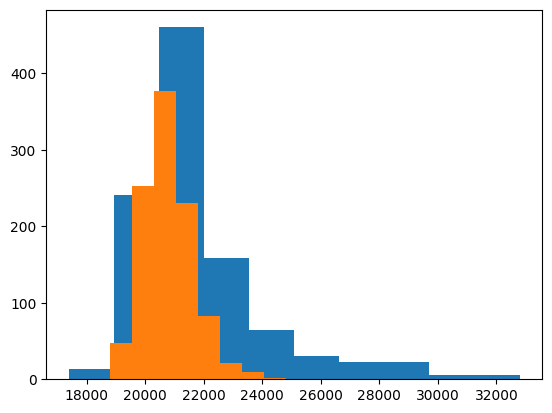

In [99]:
plt.hist(embeddings_1.take(1024)['layer_last_embeddings'][:,-3].norm(dim=1))
plt.hist(embeddings_1.take(1024)['layer_mean_embeddings'][:,-3].norm(dim=1))
plt.show()

In [289]:
emb_mat_1 = torch.stack([e['layer_last_embeddings'][-3] for e in embeddings_1.take(1024)])
emb_mat_2 = torch.stack([e['layer_last_embeddings'][-3] for e in embeddings_2.take(1024)])
emb_mat_3 = torch.stack([e['layer_last_embeddings'][-3] for e in embeddings_3.take(1024)])

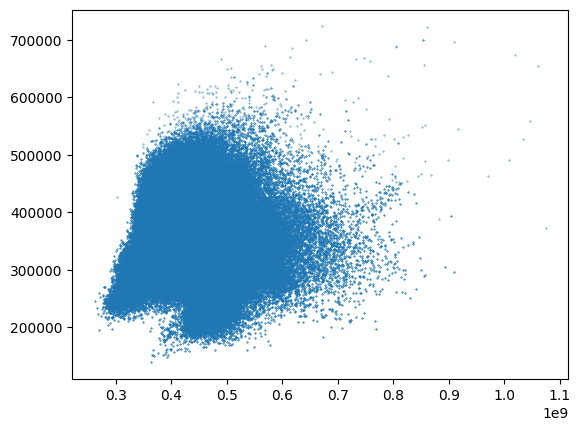

In [290]:
plt.scatter((emb_mat_1 @ emb_mat_1.T).flatten(), (emb_mat_2 @ emb_mat_2.T).flatten(), s=0.1)
plt.show()

In [132]:
# Uses dot product to get the distance. Currently does not even normalize.
def embeddings_knn(emb_mat, k):
    gram = emb_mat @ emb_mat.T
    gram.fill_diagonal_(-torch.inf)

    return gram.topk(k, sorted=False).indices

In [191]:
def intersections_mat(mat):
    n = mat.shape[0]
    k = mat.shape[1]

    out = torch.zeros(n, n, dtype=torch.int)
    for i in range(n):
        for j in range(n):
            out[i,j] = torch.isin(mat[i], mat[j], assume_unique=False).sum()

    return out

In [203]:
def mutual_knn_mat(mat):
    return intersections_mat(mat) / mat.shape[1]

In [221]:
def mutual_knn(knn_mat_1, knn_mat_2):

    assert knn_mat_1.shape == knn_mat_2.shape
    n = knn_mat_1.shape[0]
    k = knn_mat_1.shape[1]

    total = 0
    for i in range(n):
        total += torch.isin(knn_mat_1[i], knn_mat_2[i], assume_unique=True).sum()
    
    return (total / (k * n)).item()

In [283]:
def mutual_knn_vec(knn_mat_1, knn_mat_2):

    assert knn_mat_1.shape == knn_mat_2.shape
    n = knn_mat_1.shape[0]
    k = knn_mat_1.shape[1]

    out = torch.zeros(n)
    for i in range(n):
        out[i] = torch.isin(knn_mat_1[i], knn_mat_2[i], assume_unique=True).sum()
    
    return out / k

In [192]:
def jaccard_mat(mat):
    k = mat.shape[1]
    im = intersections_mat(mat)

    return im / (2 * k - im)

In [291]:
knn_mat_1 = embeddings_knn(emb_mat_1, 100)
# jaccard_1 = mutual_knn_mat(knn_mat_1)
jaccard_1 = jaccard_mat(knn_mat_1)

In [292]:
knn_mat_2 = embeddings_knn(emb_mat_2, 100)
# jaccard_2 = mutual_knn_mat(knn_mat_2)
jaccard_2 = jaccard_mat(knn_mat_2)

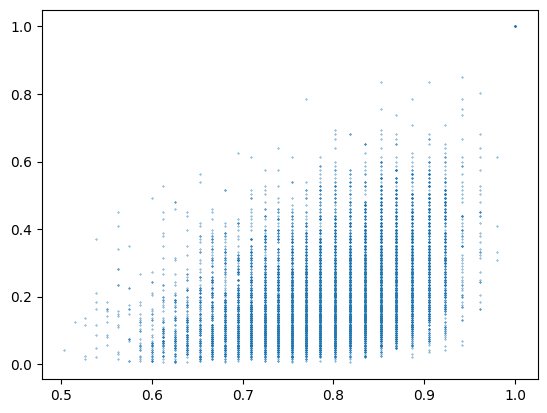

In [293]:
idxs = torch.randperm(jaccard_1.flatten().shape[0])[:10000]
plt.scatter(jaccard_1.flatten()[idxs], jaccard_2.flatten()[idxs], s=0.1)
plt.show()

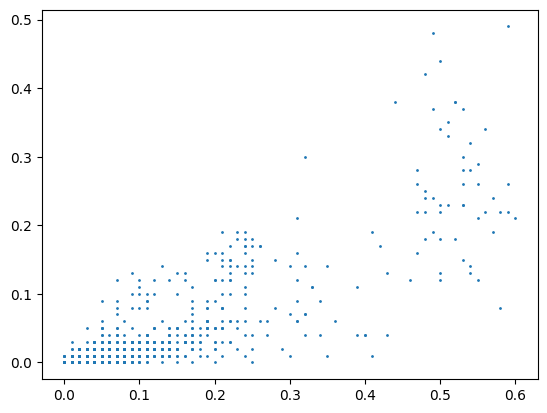

In [301]:
knn_mat_1 = embeddings_knn(emb_mat_1, 100)
knn_mat_2 = embeddings_knn(emb_mat_2, 100)
knn_mat_3 = embeddings_knn(emb_mat_3, 100)
plt.scatter(mutual_knn_vec(knn_mat_1, knn_mat_2),mutual_knn_vec(knn_mat_1, knn_mat_3), s=1)
plt.show()

In [306]:
knn_mat_1_permuted = embeddings_knn(emb_mat_1[torch.randperm(len(emb_mat_1))], 10)
knn_mat_1 = embeddings_knn(emb_mat_1, 10)
knn_mat_2 = embeddings_knn(emb_mat_2, 10)
mutual_knn(knn_mat_1_permuted, knn_mat_2)

0.01113281212747097

In [307]:
mutual_knn(knn_mat_1, knn_mat_2)

0.02724609337747097

In [308]:
k = 100
knn_mat_1 = embeddings_knn(emb_mat_1, k)
knn_mat_2 = embeddings_knn(emb_mat_2, k)

true_similarity = mutual_knn(knn_mat_1, knn_mat_2)

sim_dist = []
for i in tqdm(range(1000)):
    knn_mat_1_permuted = embeddings_knn(emb_mat_1[torch.randperm(len(emb_mat_1))], k)
    sim_dist.append(mutual_knn(knn_mat_1_permuted, knn_mat_2))

print("Permutation mean: {}\tTrue: {}".format(torch.tensor(sim_dist).mean(), true_similarity))

100%|██████████| 1000/1000 [00:29<00:00, 34.45it/s]

Permutation mean: 0.0979904979467392	True: 0.10399413853883743


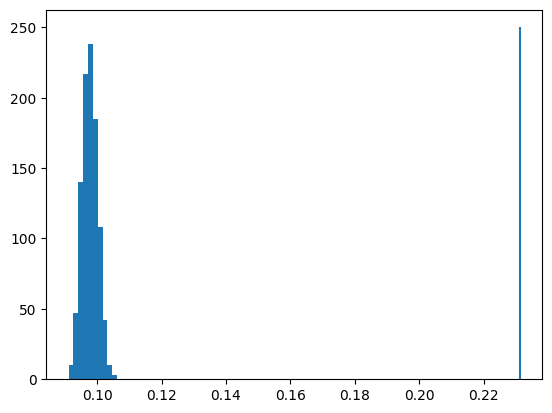

In [278]:
plt.hist(sim_dist)
plt.vlines([true_similarity], 0, 250)
plt.show()

In [32]:
imdb = datasets.load_dataset('stanfordnlp/imdb', split='train[:4096]', cache_dir=cache_dir)

In [ ]:
rw = datasets.load_dataset('tiiuae/falcon-refinedweb', split='train', streaming=True, cache_dir=cache_dir).shuffle(buffer_size=10, seed=1235).take(4096)

Resolving data files:   0%|          | 0/5534 [00:00<?, ?it/s]

In [16]:
rw

IterableDataset({
    features: ['content', 'url', 'timestamp', 'dump', 'segment', 'image_urls'],
    num_shards: 5534
})

In [30]:
for i in rw:
    print(i['timestamp'])

2022-05-16 20:52:15
2022-05-16 22:34:41
2022-05-16 23:01:49
2022-05-16 22:38:50
2022-05-16 21:58:17
2022-05-16 22:32:44
2022-05-16 21:57:55
2022-05-16 23:04:59
2022-05-16 21:28:57
2022-05-16 23:00:21
2022-05-16 21:49:18
2022-05-16 21:09:52
2022-05-16 21:04:58
2022-05-16 23:00:09
2022-05-16 22:56:57
2022-05-16 21:40:08
2022-05-16 20:54:36
2022-05-16 21:50:02
2022-05-16 22:37:57
2022-05-16 22:53:06
2022-05-16 21:38:07
2022-05-16 21:33:21
2022-05-16 22:31:58
2022-05-16 23:00:56
2022-05-16 21:58:37
2022-05-16 21:33:43
2022-05-16 21:26:01
2022-05-16 22:31:34
2022-05-16 20:57:40
2022-05-16 21:40:58
2022-05-16 22:37:42
2022-05-16 22:12:01
2022-05-16 22:11:11
2022-05-16 21:09:07
2022-05-16 21:19:07
2022-05-16 21:50:55
2022-05-16 22:17:24
2022-05-16 23:37:08
2022-05-16 21:20:41
2022-05-16 21:09:10
2022-05-16 22:26:01
2022-05-16 22:54:32
2022-05-16 22:13:06
2022-05-16 21:52:54
2022-05-16 22:48:51
2022-05-16 21:21:13
2022-05-16 22:52:48
2022-05-16 21:15:44
2022-05-16 21:31:38
2022-05-16 20:50:09


In [14]:
rw.rename_column('content', 'text').remove_columns(['url', 'timestamp', 'segment', 'image_urls'])

IterableDataset({
    features: ['text', 'dump'],
    num_shards: 5534
})

In [54]:
print(next(iter(datasets.load_dataset('tiiuae/falcon-refinedweb', split='train', streaming=True, cache_dir=cache_dir).shuffle().filter(lambda x: len(x['content']) < 10000)))['content'])

Resolving data files:   0%|          | 0/5534 [00:00<?, ?it/s]

Gina Gionfriddo’s Becky Shaw isn’t informed so much by the question “Is it better to lie than to hurt someone with the truth?” but rather by the statement, “Life is pain; lies and truth are mere tools to help one salve that pain.” Curious Theatre Company’s regional premiere of this crackling comedy brings all of the play’s East Coast energy to bear on Rocky Mountain audiences.
Becky Shaw’s setup makes it seem like a sister work to Jonathan Demme’s 1986 film Something Wild, in which a chance encounter between a straight-laced man and a manic-pixie-dream-girl careens from one crazy calamity to the next. In reality, however, Becky Shaw is much more a slice-of-life comic character study filled with deeply flawed people than an action-adventure-romance all about wish fulfillment.. Daddy’s death has thrown Suzanna and her mother, Susan (Billie McBride), into fiscal uncertainty, and Suzanna’s adopted brother, Max (Bill Hahn), is charged with sifting through the economic rubble and finding a w

In [84]:
owt = datasets.load_dataset('Skylion007/openwebtext', split='train', cache_dir=cache_dir).shuffle().to_iterable_dataset().filter(lambda x: len(x['text']) < 10000).take(4096)

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

In [87]:
owt

IterableDataset({
    features: ['text'],
    num_shards: 1
})

In [90]:
datasets.Dataset.from_list(list(owt))

Dataset({
    features: ['text'],
    num_rows: 4096
})

In [85]:
owt.save_to_disk('~/Desktop/test')

AttributeError: 'IterableDataset' object has no attribute 'save_to_disk'

In [ ]:
for r in owt:
    print(r['text'])
    print("######################################")

In [74]:
datasets.load_dataset('stanfordnlp/imdb', split='test', cache_dir=cache_dir).shuffle(seed=1234).take(4096)

Dataset({
    features: ['text', 'label'],
    num_rows: 4096
})

In [128]:
tokenizer.chat_template is None

False

In [135]:
tokenizer.apply_chat_template([{'role': 'user', 'content': 'Hello!'}], add_generation_prompt=True, truncation=True, return_tensors='pt')

tensor([[128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,   2696,
             25,   6790,    220,   2366,     18,    198,  15724,   2696,     25,
            220,   2545,   4448,    220,   2366,     20,    271, 128009, 128006,
            882, 128007,    271,   9906,      0, 128009, 128006,  78191, 128007,
            271]])

In [130]:
tokenizer.apply_chat_template([{'role': 'user', 'content': 'Hello! How are you today?'}], tokenize=False, add_generation_prompt=True)

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 08 Jan 2025\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nHello! How are you today?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n'

In [131]:
tokenizer.apply_chat_template([{'role': 'user', 'content': 'Hello! How are you today?'}], return_tensors='pt')

tensor([[128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,   2696,
             25,   6790,    220,   2366,     18,    198,  15724,   2696,     25,
            220,   2318,   4448,    220,   2366,     20,    271, 128009, 128006,
            882, 128007,    271,   9906,      0,   2650,    527,    499,   3432,
             30, 128009]])

In [110]:
tokenizer.decode([1,2,3])

'"#$'

In [3]:
import json
import os

In [10]:
with open('/Users/christopher/git/unireps/runs.json') as f:
    runs = json.load(f)

In [18]:
runs['datasets']

[{'name': 'web_text'},
 {'name': 'random_strings'},
 {'name': 'imdb_caesar'},
 {'name': 'imdb'}]

In [31]:
books = datasets.load_dataset('Helsinki-NLP/opus_books', 'de-en', split='train', cache_dir=cache_dir)

In [32]:
books.shuffle(seed=1234).take(2048)['translation']

{'de': '»Jane, ich liebe weder Spitzfindigkeiten noch Fragen; außerdem ist es gradezu widerlich, wenn ein Kind ältere Leute in dieser Weise zur Rede stellt.',
 'en': '"Jane, I don\'t like cavillers or questioners; besides, there is something truly forbidding in a child taking up her elders in that manner.'}

In [45]:
torch.manual_seed(1234)
torch.randint(100, (100,))

tensor([75, 71,  6, 65, 16, 64, 32, 25, 75, 29, 43, 41, 54, 82, 63, 42, 96, 48,
        42, 82, 98, 32, 80, 24, 49, 32, 81, 19,  2, 62, 79, 34, 44, 27, 52, 65,
        58,  6, 66, 67, 51, 15, 32, 61, 47, 24, 43, 90, 27, 16,  9, 23, 83, 39,
        70, 81, 82, 59, 27, 88,  6,  3, 74,  8,  5, 51,  5, 36, 24, 72, 69, 33,
        45, 79, 97, 59, 89, 84, 29, 88, 37, 24, 85, 52, 68, 88, 58, 68, 74,  4,
        22, 83, 39, 81, 22, 37, 82, 58, 85, 37])

In [3]:
import sys
import os

In [4]:
sys.path.append(os.path.abspath(os.path.join('..')))

In [12]:
import unireps

In [16]:
unireps.embed_dataset

{}